In [1]:
!python -m  pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.1 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete065PS8/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete065PS8/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


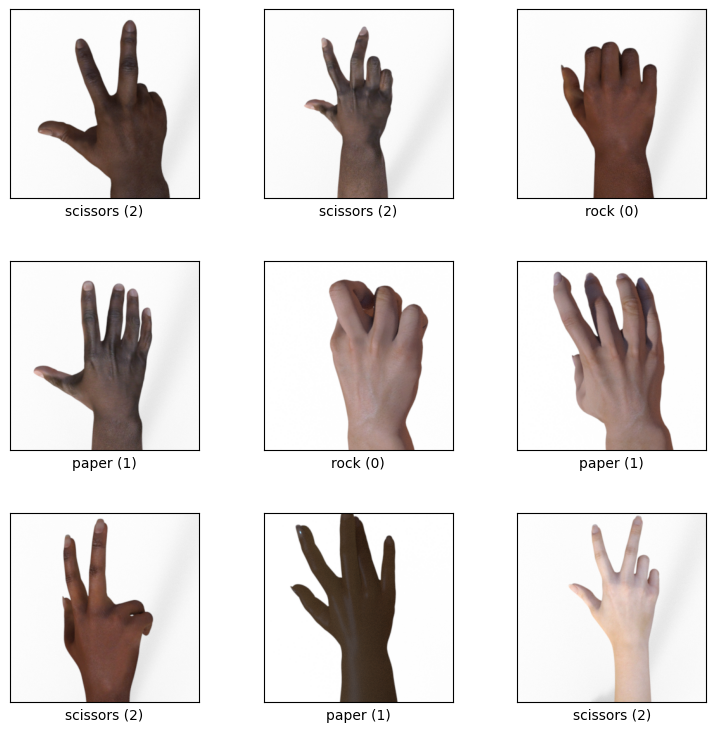

metadata: tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmp8m1jqg45tfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)
num_ex

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(100,100))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]','train[80%:]','test'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

fig = tfds.show_examples(raw_train, metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
_label = metadata.features['label']

print('metadata:',metadata)
print('num_examples',num_examples)
print('num_classes',num_classes)

['rock', 'paper', 'scissors']


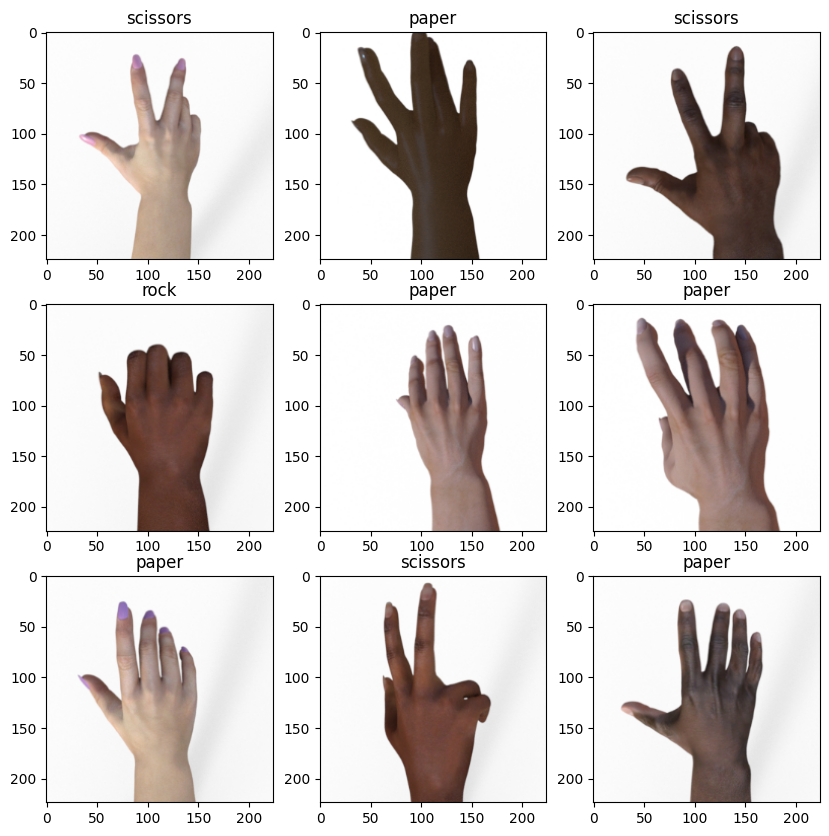

In [3]:
BATCH_SIZE = 32
class_names = ['rock','paper', 'scissors']
print(class_names)

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def resize_img(image,label):
    image = tf.image.resize(image,(224,224))
    return image, label

train_samples = raw_train.shuffle(10).map(resize_img).batch(10)

plt.figure(figsize=(10, 10))
for images, labels in train_samples.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#examples.batch(20).prefetch(1) will prefetch 1 elements (2 batches, of 20 examples each).
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

In [4]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]','train[80%:]','test'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

print(metadata)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes


BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)


####################
#케라스 허브에서 모델 가져오기
###################
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4",
                   input_shape = (224,224,3),
                   output_shape=[1280],
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

model.summary()

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
###############################
#.tflite로 변환후 추론 테스트
################################

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]','train[80%:]','test'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
#examples.batch(20).prefetch(1) will prefetch 1 elements (2 batches, of 20 examples each).

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,),
    output_shape = [FV_SIZE],
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

#학습된 모델 저장하기
#colab 버전
ROCK_PAPPERS_SCISSORS_SAVED_MODEL = "/content/drive/MyDrive/INTEL_PYTHON/exp_saved_model"
#pc 버전
#ROCK_PAPPERS_SCISSORS_SAVED_MODEL = 'exp_saved_model'
tf.saved_model.save(model, ROCK_PAPPERS_SCISSORS_SAVED_MODEL)


#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPPERS_SCISSORS_SAVED_MODEL)
tflite_model = converter.convert() # lite로 변환해주는 코드
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)


#################추론 테스트######################
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

#테스트 배치 파일을 10개 씩 가져와서
predictions =[]
test_labels, test_imgs = [],[]
for img, label in test_batches.take(10):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

print("predictions:",predictions)
print("labels:",test_labels)

#예측 수 비교
score  = 0
for item in range(0,10):
    prediction = np.argmax(predictions[item])
    label = test_labels[item]
    if prediction == label:
        score = score +1


print("10개 중 맞은 예측 수: "+ str(score))

Epoch 1/5
63/63 [==============================] - 11s 102ms/step - loss: 0.4140 - accuracy: 0.8725 - val_loss: 0.1116 - val_accuracy: 0.9921
Epoch 2/5
63/63 [==============================] - 3s 44ms/step - loss: 0.0786 - accuracy: 0.9960 - val_loss: 0.0530 - val_accuracy: 0.9980
Epoch 3/5
63/63 [==============================] - 3s 42ms/step - loss: 0.0427 - accuracy: 0.9985 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 3s 45ms/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 3s 44ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 1.0000
input:  {'name': 'serving_default_keras_layer_2_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=fl

In [8]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#244x 244 사이즈로 리사이즈를 하고, 정규화를 해줍니다.
def format_image(image,label):
    image = tf.image.resize(image,(224,224))/255.0
    return image, label

#훈련, 검증, 테스트 세트로 나눕니다.
(raw_train, raw_validation, raw_test), metadata =tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]','train[80%:]','test'],
    with_info=True,#if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo),
    as_supervised=True,#if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)


num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = raw_test.map(format_image).batch(1)

#텐서플로우 허브에 있는 mobilenet_v2 모델을 사용해 feature_extractor라는 케라스 층을 만듭니다.
#신경망의 첫번째 층
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

IMAGE_SIZE =(pixels, pixels)


feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape = IMAGE_SIZE +(3,), #(224,224,3)Expects a tensor of shape [batch_size] as input.
    output_shape = [FV_SIZE],# Outputs a tensor with shape [batch_size, 20].
    trainable = False
)

# 모델 선언
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation ='softmax')
])

model.compile(
    optimizer='adam',
    loss ='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

hist = model.fit(
    train_batches,
    epochs = 5,
    validation_data = validation_batches
)

#학습된 모델 저장하기
#colab 버전
ROCK_PAPPERS_SCISSORS_SAVED_MODEL = '/content/drive/MyDrive/INTEL_PYTHON/drq_exp_saved_model'
tf.saved_model.save(model, ROCK_PAPPERS_SCISSORS_SAVED_MODEL)


#tensoflow lite로 변환하기
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPPERS_SCISSORS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # 양자화해주는 코드
tflite_model = converter.convert()
tflite_model_file = '/content/drive/MyDrive/INTEL_PYTHON/drq_converted_model.tflite'
with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)


interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()[0]
print('input: ', input_details)
output_details = interpreter.get_output_details()[0]
print('output: ', output_details)

Epoch 1/5
63/63 [==============================] - 11s 100ms/step - loss: 0.3697 - accuracy: 0.8938 - val_loss: 0.1000 - val_accuracy: 1.0000
Epoch 2/5
63/63 [==============================] - 3s 43ms/step - loss: 0.0695 - accuracy: 0.9985 - val_loss: 0.0475 - val_accuracy: 1.0000
Epoch 3/5
63/63 [==============================] - 3s 43ms/step - loss: 0.0376 - accuracy: 0.9995 - val_loss: 0.0295 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 3s 45ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 3s 45ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
input:  {'name': 'serving_default_keras_layer_3_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=fl